## Defining the input data


In [1]:
import numpy as np
from pyomo.environ import *


# Initialize the model
model = ConcreteModel()

# Define sets
num_periods = 24       # Number of time periods (e.g., hours in a day)
num_scenarios = 5    # Number of scenarios

model.T = RangeSet(1, num_periods)       # Time periods
model.W = RangeSet(1, num_scenarios)     # Scenarios

# Generate day-ahead prices for each hour 
price_day_ahead_data = [29.56,28.46,26.66,24.48,24.01,21.23,22.62,25.04,26.24,32.21,41.34,43.51,43.02,44.29,46.24,50.61,59.47,64.99,61.74,55.07,48.01,44.01,45.2,38]

# Convert day-ahead prices to a NumPy array
price_day_ahead_array = np.array(price_day_ahead_data)

# Define deviations for intraday prices
mean_deviation_open_buy = -1    # Intraday opening buy prices are slightly lower on average
std_deviation_open_buy = 2

mean_deviation_open_sell = 1    # Intraday opening sell prices are slightly higher on average
std_deviation_open_sell = 2

mean_deviation_second_buy = -2   # Intraday secondary buy prices are even lower
std_deviation_second_buy = 4

mean_deviation_second_sell = 2   # Intraday secondary sell prices are higher
std_deviation_second_sell = 4

# Intraday opening buy prices
price_intraday_open_buy_data = price_day_ahead_array + np.random.normal(mean_deviation_open_buy, std_deviation_open_buy, num_periods)
price_intraday_open_buy_data = np.maximum(price_intraday_open_buy_data, 0)  # Ensure non-negative prices

# Intraday opening sell prices
price_intraday_open_sell_data = price_day_ahead_array + np.random.normal(mean_deviation_open_sell, std_deviation_open_sell, num_periods)
price_intraday_open_sell_data = np.maximum(price_intraday_open_sell_data, 0)

# Intraday secondary buy prices
price_intraday_second_buy_data = price_day_ahead_array.reshape(-1,1) + np.random.normal(mean_deviation_second_buy, std_deviation_second_buy, (num_periods, num_scenarios))
price_intraday_second_buy_data = np.maximum(price_intraday_second_buy_data, 0)

# Intraday secondary sell prices
price_intraday_second_sell_data = price_day_ahead_array.reshape(-1,1) + np.random.normal(mean_deviation_second_sell, std_deviation_second_sell, (num_periods, num_scenarios))
price_intraday_second_sell_data = np.maximum(price_intraday_second_sell_data, 0)

# Day-Ahead Price
price_day_ahead_dict = {t+1: price_day_ahead_data[t] for t in range(num_periods)}

# Intraday Opening Prices
price_intraday_open_buy_dict = {t+1: price_intraday_open_buy_data[t] for t in range(num_periods)}
price_intraday_open_sell_dict = {t+1: price_intraday_open_sell_data[t] for t in range(num_periods)}

# Intraday Secondary Prices
price_intraday_second_buy_dict = {(t+1, w+1): price_intraday_second_buy_data[t, w] for t in range(num_periods) for w in range(num_scenarios)}
price_intraday_second_sell_dict = {(t+1, w+1): price_intraday_second_sell_data[t, w] for t in range(num_periods) for w in range(num_scenarios)}



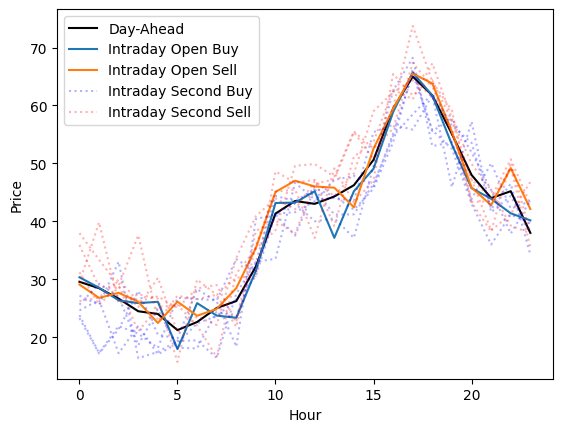

In [2]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(price_day_ahead_data, label='Day-Ahead', color='black')
plt.plot(price_intraday_open_buy_data, label='Intraday Open Buy')
plt.plot(price_intraday_open_sell_data, label='Intraday Open Sell')

for w in range(num_scenarios):
    # Plot Intraday Second Buy prices
    plt.plot(price_intraday_second_buy_data[:, w], color='blue', linestyle='dotted',
             label='Intraday Second Buy' if w == 0 else '_nolegend_', alpha=0.3)
    # Plot Intraday Second Sell prices
    plt.plot(price_intraday_second_sell_data[:, w], color='red', linestyle='dotted',
             label='Intraday Second Sell' if w == 0 else '_nolegend_', alpha=0.3)

plt.xlabel('Hour')
plt.ylabel('Price')
plt.legend()
plt.show()


## 1) Model optimization

In [57]:

# Initialize the model
model = ConcreteModel()

model.T = RangeSet(1, num_periods)       # Time periods
model.W = RangeSet(1, num_scenarios)     # Scenarios


# Day-Ahead Price Parameter
model.price_day_ahead = Param(model.T, initialize=price_day_ahead_dict, within=NonNegativeReals)

# Intraday Opening Prices
model.price_intraday_open_buy = Param(model.T, initialize=price_intraday_open_buy_dict, within=NonNegativeReals)
model.price_intraday_open_sell = Param(model.T, initialize=price_intraday_open_sell_dict, within=NonNegativeReals)

# Intraday Secondary Prices
model.price_intraday_second_buy = Param(model.T, model.W, initialize=price_intraday_second_buy_dict, within=NonNegativeReals)
model.price_intraday_second_sell = Param(model.T, model.W, initialize=price_intraday_second_sell_dict, within=NonNegativeReals)



# Battery parameters
model.eta = Param(initialize=0.9)                 # Battery efficiency
model.capacity = Param(initialize=1.0)          # Battery capacity (MWh, for example)
model.energy_capacity = Param(initialize=2.0)   # Energy capacity (MWh, for example)
model.SOC_0 = model.energy_capacity/2           # Initial state of charge (as a fraction of capacity)
model.cost_cycle = Param(initialize=45)         # Cost per cycle (monetary units)

# # Maximum charge/discharge rates
# model.max_charge_rate = Param(initialize=your_max_charge_rate)
# model.max_discharge_rate = Param(initialize=your_max_discharge_rate)



# Initialize model, sets, parameters as above...

# Define Variables
model.x_da_buy = Var(model.T, within=NonNegativeReals, bounds=(0, model.capacity))
model.x_da_sell = Var(model.T, within=NonNegativeReals, bounds=(0, model.capacity))

model.x_intraday_open_buy = Var(model.T, within=NonNegativeReals, bounds=(0, model.capacity))
model.x_intraday_open_sell = Var(model.T, within=NonNegativeReals, bounds=(0, model.capacity))

model.x_intraday_second_buy = Var(model.T, model.W, within=NonNegativeReals, bounds=(0, model.capacity))
model.x_intraday_second_sell = Var(model.T, model.W, within=NonNegativeReals, bounds=(0, model.capacity))

model.charge = Var(model.T, model.W, within=NonNegativeReals)
model.discharge = Var(model.T, model.W, within=NonNegativeReals)


model.ID_position = Var(model.T, model.W, within=Reals)
model.ID_pos = Var(model.T, model.W, within=NonNegativeReals)
model.ID_neg = Var(model.T, model.W, within=NonNegativeReals)

model.SOC = Var(model.T, model.W, within=NonNegativeReals, bounds=(0, model.energy_capacity))


# # constraint on the ID_position variable
# def ID_position_rule(model, t, w):
#     return model.ID_position[t, w] == model.x_intraday_open_sell[t] - model.x_intraday_open_buy[t] + model.x_intraday_second_sell[t, w] - model.x_intraday_second_buy[t, w]

# constraint on the ID_position variable
def ID_position_rule(model, t, w):
    return (model.ID_pos[t, w]-model.ID_neg[t, w]) == model.x_intraday_open_sell[t] - model.x_intraday_open_buy[t] + model.x_intraday_second_sell[t, w] - model.x_intraday_second_buy[t, w]

model.ID_position_constraint = Constraint(model.T, model.W, rule=ID_position_rule)


# Define Objective Function
# Objective function: maximize total profit
# def total_throughput_rule(model):
#     return (1 / num_scenarios) * model.cost_cycle * sum(
#         sum(model.charge[t, w] + model.discharge[t, w] for w in model.W) for t in model.T
#     )
# cycle_cost = total_throughput_rule(model)


def objective_function(model):
    # Day-Ahead Market Profit
    da_profit = sum(
        model.price_day_ahead[t] * model.x_da_sell[t]     # Revenue from selling
        - model.price_day_ahead[t] * model.x_da_buy[t]    # Cost from buying
        for t in model.T
    )
    
    # Intraday Opening Market Profit
    intraday_open_profit = sum(
        model.price_intraday_open_sell[t] * model.x_intraday_open_sell[t]
        - model.price_intraday_open_buy[t] * model.x_intraday_open_buy[t]
        for t in model.T
    )
    
    # Intraday Secondary Market Profit (Expected over scenarios)
    intraday_second_profit = (1 / num_scenarios) * sum(
        sum(
            model.price_intraday_second_sell[t, w] * model.x_intraday_second_sell[t, w]
            - model.price_intraday_second_buy[t, w] * model.x_intraday_second_buy[t, w]
            for w in model.W
        )
        for t in model.T
    )

    # intraday_position_cost = (1 / num_scenarios) * sum(
    #     sum(
    #         model.price_day_ahead[t] * model.ID_position[t, w]
    #         for w in model.W
    #     )
    #     for t in model.T
    # )
    
    intraday_position_cost = (1 / num_scenarios) * sum(
        sum(
            model.price_day_ahead[t] * (model.ID_pos[t, w]-model.ID_neg[t, w])
            for w in model.W
        )
        for t in model.T
    )
    
    # # Cycling Cost (Expected over scenarios)
    # cycle_cost = (1 / num_scenarios) * model.cost_cycle * sum(
    #     sum(model.x_da_sell[t] + model.x_da_buy[t] + model.ID_position[t, w]
    #         for w in model.W ) for t in model.T)
    
        # Cycling Cost (Expected over scenarios)
    cycle_cost = (1 / num_scenarios) * model.cost_cycle * sum(
        sum(model.x_da_sell[t] + model.x_da_buy[t] + (model.ID_pos[t, w]+model.ID_neg[t, w])
            for w in model.W ) for t in model.T)
    


    # # Cycling Cost (Expected over scenarios)
    # cycle_cost = (1 / num_scenarios) * model.cost_cycle * sum(
    #     sum(model.charge[t, w] + model.discharge[t, w] for w in model.W) for t in model.T)

    
    return da_profit + intraday_open_profit + intraday_second_profit + intraday_position_cost - cycle_cost

model.obj = Objective(rule=objective_function, sense=maximize)



# def SOC_balance_rule(model, t, w):
#     if t == 1:
#         prev_SOC = model.SOC_0
#     else:
#         prev_SOC = model.SOC[t - 1, w]
    
#     # Net energy change (positive for charging, negative for discharging)
#     net_energy = (
#         - model.x_da_sell[t] + model.x_da_buy[t] - model.ID_position[t, w]
#     )
    
#     # Update SOC considering battery efficiency
#     return model.SOC[t, w] == prev_SOC + model.eta * net_energy
#model.SOC_balance = Constraint(model.T, model.W, rule=SOC_balance_rule)

def SOC_balance_rule(model, t, w):
    if t == 1:
        prev_SOC = model.SOC_0
    else:
        prev_SOC = model.SOC[t - 1, w]
    return model.SOC[t, w] == prev_SOC + model.eta * model.charge[t, w] - (1 / model.eta) * model.discharge[t, w]
model.SOC_balance = Constraint(model.T, model.W, rule=SOC_balance_rule)

def charge_balance_rule(model, t, w):
    return model.charge[t, w] == model.x_da_buy[t] + model.x_intraday_open_buy[t] + model.x_intraday_second_buy[t, w]
model.charge_balance = Constraint(model.T, model.W, rule=charge_balance_rule)

def discharge_balance_rule(model, t, w):
    return model.discharge[t, w] == model.x_da_sell[t] + model.x_intraday_open_sell[t] + model.x_intraday_second_sell[t, w]
model.discharge_balance = Constraint(model.T, model.W, rule=discharge_balance_rule)


# State of charge constraints
def SOC_limit_rule(model, t, w):
    return model.SOC[t, w] <= model.energy_capacity
model.SOC_limit = Constraint(model.T, model.W, rule=SOC_limit_rule)

# def power_limit_rule_buy(model, t, w):
#     return model.x_da_buy[t] + model.x_intraday_open_buy[t] + model.x_intraday_second_buy[t, w] <= model.capacity
# model.power_limit_buy = Constraint(model.T, model.W, rule=power_limit_rule_buy)

# def power_limit_rule_sell(model, t, w):
#     return model.x_da_sell[t] + model.x_intraday_open_sell[t] + model.x_intraday_second_sell[t, w] <= model.capacity
# model.power_limit_sell = Constraint(model.T, model.W, rule=power_limit_rule_sell)




# Solve the model
solver = SolverFactory('glpk')  # Replace with appropriate solver
results = solver.solve(model)

# Display results
#model.display()

# Extract results of day-ahead market and intraday market opening
da_buy_results = np.array([model.x_da_buy[t]() for t in model.T])
da_sell_results = np.array([model.x_da_sell[t]() for t in model.T])

intraday_open_buy_results = np.array([model.x_intraday_open_buy[t]() for t in model.T])
intraday_open_sell_results = np.array([model.x_intraday_open_sell[t]() for t in model.T])

# Extract results of intraday market secondary
intraday_second_buy_results = np.array([[model.x_intraday_second_buy[t, w]() for t in model.T] for w in model.W])
intraday_second_sell_results = np.array([[model.x_intraday_second_sell[t, w]() for t in model.T] for w in model.W])

# Extract results of state of charge
SOC_results = np.array([[model.SOC[t, w]() for t in model.T] for w in model.W])

# # Extract results of ID position
# ID_position_results = np.array([[model.ID_position[t, w]() for t in model.T] for w in model.W])

# Extract results of ID position
ID_position_results = np.array([[(model.ID_pos[t, w]()+model.ID_neg[t, w]()) for t in model.T] for w in model.W])

Objective Function Value:  81.68


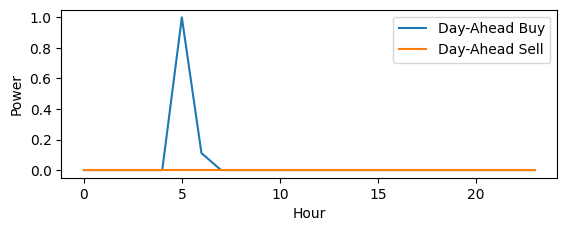

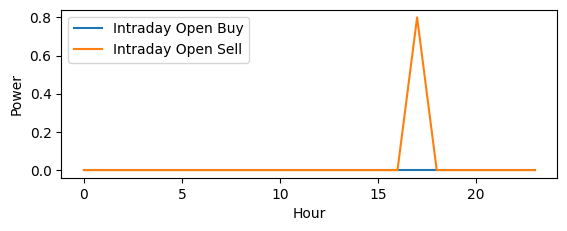

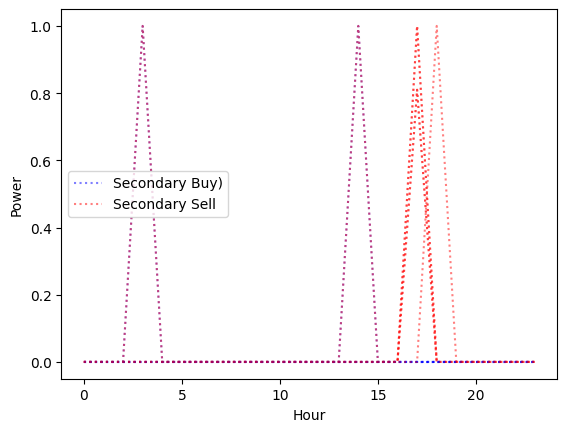

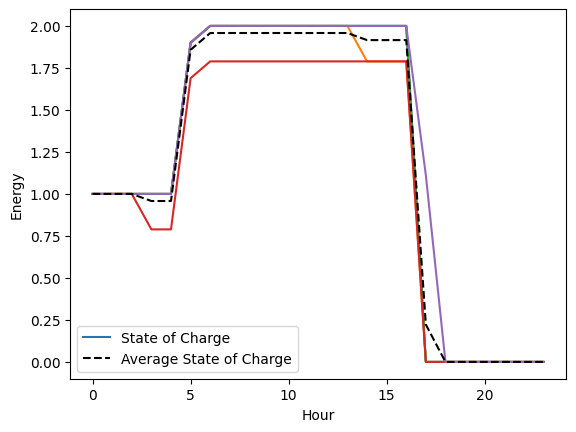

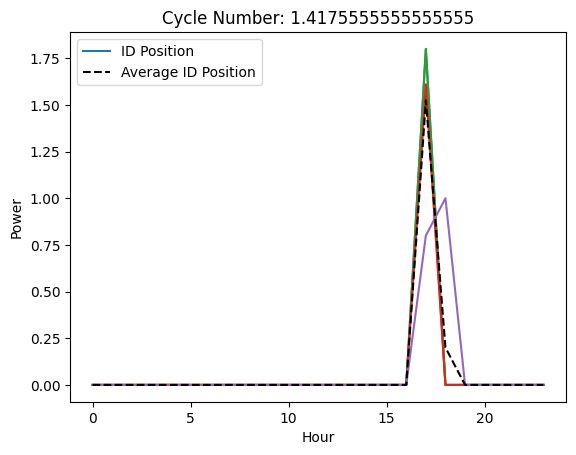

In [58]:
# Print the value of the objective function
print('Objective Function Value: ', round(model.obj(),2))
plt.subplot(2, 1, 1)
plt.plot(da_buy_results, label='Day-Ahead Buy')
plt.plot(da_sell_results, label='Day-Ahead Sell')
plt.xlabel('Hour')
plt.ylabel('Power')
plt.legend()
plt.show()
plt.subplot(2, 1, 1)
plt.plot(intraday_open_buy_results, label='Intraday Open Buy')
plt.plot(intraday_open_sell_results, label='Intraday Open Sell')
plt.xlabel('Hour')
plt.ylabel('Power')
plt.legend()
plt.show()



# Plot secondary market results
plt.figure()
for w in range(num_scenarios):
    plt.plot(intraday_second_buy_results[w], label=f'Secondary Buy)' if w == 0 else '_nolegend_', linestyle='dotted', color='blue', alpha=0.5)
    plt.plot(intraday_second_sell_results[w], label=f'Secondary Sell' if w == 0 else '_nolegend_', linestyle='dotted', color='red', alpha=0.5)
plt.xlabel('Hour')
plt.ylabel('Power')
plt.legend()
plt.show()

# Plot state of charge results
plt.figure()
for w in range(num_scenarios):
    plt.plot(SOC_results[w], label=f'State of Charge' if w == 0 else '_nolegend_')
#plot average state of charge
plt.plot(np.mean(SOC_results, axis=0), label='Average State of Charge', color='black', linestyle='dashed')
plt.xlabel('Hour')
plt.ylabel('Energy')
plt.legend()
plt.show()

# # plot ID position results and average
# cycle_number = (1 / num_scenarios)* sum(
#         sum(  model.x_da_sell[t]() + model.x_da_buy[t]() + model.ID_position[t, w]()
#             for w in model.W
#         )
#         for t in model.T
#     )

# plot ID position results and average
cycle_number = (1 / num_scenarios)* sum(
        sum(  model.x_da_sell[t]() + model.x_da_buy[t]() +(model.ID_pos[t, w]()+model.ID_neg[t, w]())
            for w in model.W
        )
        for t in model.T
    )


plt.figure()
for w in range(num_scenarios):
    plt.plot(ID_position_results[w], label=f'ID Position' if w == 0 else '_nolegend_')

plt.plot(np.mean(ID_position_results, axis=0), label='Average ID Position', color='black', linestyle='dashed')
plt.title(f'Cycle Number: {cycle_number/model.energy_capacity}')
plt.xlabel('Hour')
plt.ylabel('Power')
plt.legend()
plt.show()






In [81]:
# save the results to a csv file
import pandas as pd

# Create a DataFrame for the results
results_df = pd.DataFrame({
    'Hour': range(1, num_periods+1),
    'Day-Ahead Buy': da_buy_results,
    'Day-Ahead Sell': da_sell_results,
    'Intraday Open Buy': intraday_open_buy_results,
    'Intraday Open Sell': intraday_open_sell_results,
})

# Add columns for secondary market results
for w in range(num_scenarios):
    results_df[f'Secondary Buy (Scenario {w+1})'] = intraday_second_buy_results[w]
    results_df[f'Secondary Sell (Scenario {w+1})'] = intraday_second_sell_results[w]

# Add columns for state of charge results
for w in range(num_scenarios):
    results_df[f'State of Charge (Scenario {w+1})'] = SOC_results[w]

# Add columns for ID position results
for w in range(num_scenarios):
    results_df[f'ID Position (Scenario {w+1})'] = ID_position_results[w]
    
# Save the DataFrame to a CSV file  
results_df.to_csv('intraday_results.csv', index=False)

## Generated data for trades for all hours

In [99]:
import pandas as pd
import numpy as np

# Define the start and end times for simulation and operation
simulation_start = pd.Timestamp('2024-09-30 14:00')  # Simulation starts at 14:00 the day before
simulation_end = pd.Timestamp('2024-10-01 23:00')    # Simulation ends at 23:00 on the day of operation
operation_start = pd.Timestamp('2024-10-01 00:00')   # Operation starts at 00:00 the day of operation
operation_end = pd.Timestamp('2024-10-01 23:00')     # Operation ends at 23:00 the day of operation

# Create a range of simulation hours
simulation_hours = pd.date_range(simulation_start, simulation_end, freq='H')

# Create a range of operation hours
operation_hours = pd.date_range(operation_start, operation_end, freq='H')

# Number of buy and sell orders per operation hour in each simulation hour
num_orders = 10

# Prepare a dataframe to store buy and sell positions for each simulation hour and each operation hour
data = []

for sim_hour in simulation_hours:
    # Determine remaining operation hours based on the current simulation hour
    # Only include future operation hours, i.e., operation hours > simulation hour
    remaining_operation_hours = operation_hours[operation_hours > sim_hour]
    
    for op_hour in remaining_operation_hours:
        # Generate random buy and sell orders for the current operation hour
        for order in range(num_orders):
            buy_position = np.random.uniform(0, 100)  # Random buy order
            sell_position = np.random.uniform(0, 100)  # Random sell order
            
            # Append the simulation hour, operation hour, and order data to the list
            data.append([sim_hour, op_hour, order + 1, buy_position, sell_position])

# Convert to a pandas dataframe
df = pd.DataFrame(data, columns=['Simulation_Hour', 'Operation_Hour', 'Order_Number', 'Buy_Position', 'Sell_Position'])




In [100]:
df

,Simulation_Hour,Operation_Hour,Order_Number,Buy_Position,Sell_Position
0,2024-09-30 14:00:00,2024-10-01 00:00:00,1,96.722112,91.180989
1,2024-09-30 14:00:00,2024-10-01 00:00:00,2,81.656368,40.382631
2,2024-09-30 14:00:00,2024-10-01 00:00:00,3,88.029085,50.161458
3,2024-09-30 14:00:00,2024-10-01 00:00:00,4,80.879980,13.468686
4,2024-09-30 14:00:00,2024-10-01 00:00:00,5,71.029082,89.518066
...,...,...,...,...,...
5155,2024-10-01 22:00:00,2024-10-01 23:00:00,6,78.016418,67.484482
5156,2024-10-01 22:00:00,2024-10-01 23:00:00,7,21.225545,49.692874
5157,2024-10-01 22:00:00,2024-10-01 23:00:00,8,61.812386,93.880090
5158,2024-10-01 22:00:00,2024-10-01 23:00:00,9,94.924756,56.974321


## New Model - V1

In [102]:
import pandas as pd
import numpy as np
from pyomo.environ import *

# Define the start and end times for simulation and operation
simulation_start = pd.Timestamp('2024-09-30 14:00')  # Simulation starts at 14:00 the day before
simulation_end = pd.Timestamp('2024-10-01 23:00')    # Simulation ends at 23:00 the day before
operation_start = pd.Timestamp('2024-10-01 00:00')   # Operation starts at 00:00 the day of operation
operation_end = pd.Timestamp('2024-10-01 23:00')     # Operation ends at 23:00 the day of operation

# Create a range of simulation hours
simulation_hours = pd.date_range(simulation_start, simulation_end, freq='H')

# Create a range of operation hours
operation_hours = pd.date_range(operation_start, operation_end, freq='H')

# Number of buy and sell orders per operation hour
num_orders = 10

# Battery parameters
battery_capacity = 1.0       # Max power capacity (MW)
battery_energy_capacity = 2.0  # Max energy capacity (MWh)
battery_efficiency = 0.9
initial_SOC = battery_energy_capacity / 2  # Initial state of charge (MWh)
cost_cycle = 20  # Cost per cycle

# Generate day-ahead prices for each hour (Assuming same for all simulation hours)
price_day_ahead_data = [29.56,28.46,26.66,24.48,24.01,21.23,22.62,25.04,26.24,32.21,41.34,43.51,43.02,44.29,46.24,50.61,59.47,64.99,61.74,55.07,48.01,44.01,45.2,38]

# Store results for each simulation hour
results_list = []

# Initialize dataframes to store the prices
day_ahead_prices_df = pd.DataFrame(columns=['Simulation_Hour', 'Operation_Hour', 'Day_Ahead_Price'])
intraday_prices_df = pd.DataFrame(columns=['Simulation_Hour', 'Operation_Hour', 'Order_Number', 'Intraday_Buy_Price', 'Intraday_Sell_Price'])

# Store rows in a list to avoid the need for repeated DataFrame modifications
day_ahead_prices_list = []
intraday_prices_list = []


for sim_hour in simulation_hours:
    # Determine remaining operation hours based on the current simulation hour
    remaining_operation_hours = operation_hours[operation_hours > sim_hour]

    num_periods = len(remaining_operation_hours)
    periods = range(num_periods)

    # Map periods to actual operation hours
    period_to_operation_hour = {t: remaining_operation_hours[t] for t in periods}

    # Generate intraday buy and sell prices for remaining operation hours
    price_intraday_buy = np.random.uniform(30, 40, (num_periods, num_orders))   # Example buy prices
    price_intraday_sell = np.random.uniform(50, 60, (num_periods, num_orders)) # Example sell prices
 
            # For each period, generate intraday buy and sell prices as a deviation from the day-ahead price
    for t in periods:
        da_price = price_day_ahead_data[(period_to_operation_hour[t].hour) % 24]  # Day-ahead price for the period
        # Generate intraday buy and sell prices as deviations from the day-ahead price
        price_intraday_buy[t, :] = da_price + np.random.uniform(-10, 0, num_orders)  # Deviation for buy prices
        price_intraday_sell[t, :] = da_price + np.random.uniform(0, 10, num_orders)  # Deviation for sell prices


    # Define the model
    model = ConcreteModel()

    # Sets
    model.T = RangeSet(0, num_periods - 1)  # Time periods (indices)
    model.O = RangeSet(1, num_orders)       # Orders within each hour

    # Parameters
    # Day-Ahead Price (Assuming the same as before)
    model.price_day_ahead = Param(model.T, initialize=lambda model, t: price_day_ahead_data[(period_to_operation_hour[t].hour)%24], within=NonNegativeReals)

    # Intraday Buy and Sell Prices
    model.price_intraday_buy = Param(model.T, model.O, initialize=lambda model, t, o: price_intraday_buy[t, o - 1], within=NonNegativeReals)
    model.price_intraday_sell = Param(model.T, model.O, initialize=lambda model, t, o: price_intraday_sell[t, o - 1], within=NonNegativeReals)




    # save the day-ahead prices and intraday prices to a dataframe and oppend for each simulation hour

    # Store day-ahead prices in the list
    for t in periods:
        day_ahead_price = price_day_ahead_data[(period_to_operation_hour[t].hour)%24]
        day_ahead_prices_list.append({
            'Simulation_Hour': sim_hour,
            'Operation_Hour': period_to_operation_hour[t],
            'Day_Ahead_Price': day_ahead_price
        })
    
    # Store intraday buy and sell prices in the list
    for t in periods:
        for o in range(num_orders):
            intraday_prices_list.append({
                'Simulation_Hour': sim_hour,
                'Operation_Hour': period_to_operation_hour[t],
                'Order_Number': o + 1,
                'Intraday_Buy_Price': price_intraday_buy[t, o],
                'Intraday_Sell_Price': price_intraday_sell[t, o]
            })

    # Battery parameters
    model.eta = Param(initialize=battery_efficiency)                    # Battery efficiency
    model.capacity = Param(initialize=battery_capacity)                 # Battery capacity (MW)
    model.energy_capacity = Param(initialize=battery_energy_capacity)   # Energy capacity (MWh)
    model.SOC_0 = Param(initialize=initial_SOC)                         # Initial state of charge (MWh)
    model.cost_cycle = Param(initialize=cost_cycle)                     # Cost per cycle

    # Variables
    model.x_da_buy = Var(model.T, within=NonNegativeReals, bounds=(0, model.capacity))
    model.x_da_sell = Var(model.T, within=NonNegativeReals, bounds=(0, model.capacity))

    model.x_intraday_buy = Var(model.T, model.O, within=NonNegativeReals, bounds=(0, model.capacity))
    model.x_intraday_sell = Var(model.T, model.O, within=NonNegativeReals, bounds=(0, model.capacity))

    model.SOC = Var(model.T, within=NonNegativeReals, bounds=(0, model.energy_capacity))

    # SOC balance
    def SOC_balance_rule(model, t):
        if t == 0:
            prev_SOC = model.SOC_0
        else:
            prev_SOC = model.SOC[t - 1]

        net_energy = (
            model.x_da_buy[t] - model.x_da_sell[t]
            + sum(model.x_intraday_buy[t, o] - model.x_intraday_sell[t, o] for o in model.O)
        )

        # Battery SOC balance with efficiency consideration
        return model.SOC[t] == prev_SOC + model.eta * net_energy

    model.SOC_balance = Constraint(model.T, rule=SOC_balance_rule)

    # Objective function
    def objective_function(model):
        # Day-Ahead Market Profit
        da_profit = sum(
            model.price_day_ahead[t] * model.x_da_sell[t]    # Revenue from selling
            - model.price_day_ahead[t] * model.x_da_buy[t]   # Cost from buying
            for t in model.T
        )

        # Intraday Market Profit
        intraday_profit = sum(
            sum(
                model.price_intraday_sell[t, o] * model.x_intraday_sell[t, o]  # Revenue from selling
                - model.price_intraday_buy[t, o] * model.x_intraday_buy[t, o]  # Cost from buying
                for o in model.O
            )
            for t in model.T
        )

        # Cycling cost
        cycle_cost = model.cost_cycle * sum(
            model.x_da_sell[t] + model.x_da_buy[t]
            + sum(model.x_intraday_sell[t, o] + model.x_intraday_buy[t, o] for o in model.O)
            for t in model.T
        )

        return da_profit + intraday_profit - cycle_cost

    model.obj = Objective(rule=objective_function, sense=maximize)

    # State of charge limit constraint
    def SOC_limit_rule(model, t):
        return model.SOC[t] <= model.energy_capacity

    model.SOC_limit = Constraint(model.T, rule=SOC_limit_rule)

    # Optional: Power capacity constraints
    def power_limit_rule_buy(model, t):
        return model.x_da_buy[t] + sum(model.x_intraday_buy[t, o] for o in model.O) <= model.capacity
    model.power_limit_buy = Constraint(model.T, rule=power_limit_rule_buy)

    def power_limit_rule_sell(model, t):
        return model.x_da_sell[t] + sum(model.x_intraday_sell[t, o] for o in model.O) <= model.capacity
    model.power_limit_sell = Constraint(model.T, rule=power_limit_rule_sell)

    # Solve the model
    solver = SolverFactory('glpk')
    results = solver.solve(model)

    # Extract results
    da_buy_results = np.array([model.x_da_buy[t]() for t in model.T])
    da_sell_results = np.array([model.x_da_sell[t]() for t in model.T])

    intraday_buy_results = np.array([[model.x_intraday_buy[t, o]() for o in model.O] for t in model.T])
    intraday_sell_results = np.array([[model.x_intraday_sell[t, o]() for o in model.O] for t in model.T])

    SOC_results = np.array([model.SOC[t]() for t in model.T])

    # Store results
    results_list.append({
        'Simulation_Hour': sim_hour,
        'Operation_Hours': [period_to_operation_hour[t] for t in model.T],
        'DA_Buy': da_buy_results,
        'DA_Sell': da_sell_results,
        'Intraday_Buy': intraday_buy_results,
        'Intraday_Sell': intraday_sell_results,
        'SOC': SOC_results,
        'Objective': model.obj()
    })


# Convert lists to dataframes
day_ahead_prices_df = pd.concat([day_ahead_prices_df, pd.DataFrame(day_ahead_prices_list)], ignore_index=True)
intraday_prices_df = pd.concat([intraday_prices_df, pd.DataFrame(intraday_prices_list)], ignore_index=True)




# After the loop, you can process the results_list as needed
# For example, print the results for each simulation hour
for result in results_list:
    print(f"Simulation Hour: {result['Simulation_Hour']}")
    print(f"Objective Value: {result['Objective']}")
    print("Operation Hours:", result['Operation_Hours'])
    print("DA Buy:", result['DA_Buy'])
    print("DA Sell:", result['DA_Sell'])
    print("State of Charge:", result['SOC'])
    print("\n")


Simulation Hour: 2024-09-30 14:00:00
Objective Value: 79.98597195920141
Operation Hours: [Timestamp('2024-10-01 00:00:00'), Timestamp('2024-10-01 01:00:00'), Timestamp('2024-10-01 02:00:00'), Timestamp('2024-10-01 03:00:00'), Timestamp('2024-10-01 04:00:00'), Timestamp('2024-10-01 05:00:00'), Timestamp('2024-10-01 06:00:00'), Timestamp('2024-10-01 07:00:00'), Timestamp('2024-10-01 08:00:00'), Timestamp('2024-10-01 09:00:00'), Timestamp('2024-10-01 10:00:00'), Timestamp('2024-10-01 11:00:00'), Timestamp('2024-10-01 12:00:00'), Timestamp('2024-10-01 13:00:00'), Timestamp('2024-10-01 14:00:00'), Timestamp('2024-10-01 15:00:00'), Timestamp('2024-10-01 16:00:00'), Timestamp('2024-10-01 17:00:00'), Timestamp('2024-10-01 18:00:00'), Timestamp('2024-10-01 19:00:00'), Timestamp('2024-10-01 20:00:00'), Timestamp('2024-10-01 21:00:00'), Timestamp('2024-10-01 22:00:00'), Timestamp('2024-10-01 23:00:00')]
DA Buy: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
DA Sell: [0.

C:\Users\khoda\AppData\Local\Temp\ipykernel_50436\1272198846.py:209: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  day_ahead_prices_df = pd.concat([day_ahead_prices_df, pd.DataFrame(day_ahead_prices_list)], ignore_index=True)
C:\Users\khoda\AppData\Local\Temp\ipykernel_50436\1272198846.py:210: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  intraday_prices_df = pd.concat([intraday_prices_df, pd.DataFrame(intraday_prices_list)], ignore_index=True)


In [ ]:
results_list

In [ ]:
intraday_prices_df.tail(60)

## New Model - V2

In [150]:
import pandas as pd
import numpy as np
from pyomo.environ import *

# Define the start and end times for simulation and operation
simulation_start = pd.Timestamp('2024-10-01 19:00')  # Simulation starts at 14:00 the day before
simulation_end = pd.Timestamp('2024-10-01 23:00')    # Simulation ends at 23:00 the day before
operation_start = pd.Timestamp('2024-10-01 20:00')   # Operation starts at 00:00 the day of operation
operation_end = pd.Timestamp('2024-10-01 23:00')     # Operation ends at 23:00 the day of operation

# Create a range of simulation hours
simulation_hours = pd.date_range(simulation_start, simulation_end, freq='H')

# Create a range of operation hours
operation_hours = pd.date_range(operation_start, operation_end, freq='H')

# Number of buy and sell orders per operation hour
num_orders = 10

# Battery parameters
battery_capacity = 1.0          # Max power capacity (MW)
battery_energy_capacity = 2.0   # Max energy capacity (MWh)
battery_efficiency = 1.0
initial_SOC = battery_energy_capacity / 2  # Initial state of charge (MWh)
cost_cycle = 20  # Cost per cycle

# Generate day-ahead prices for each hour (Assuming same for all simulation hours)
price_day_ahead_data = [29.56, 28.46, 26.66, 24.48, 24.01, 21.23, 22.62, 25.04, 26.24, 32.21, 41.34, 43.51, 43.02, 44.29, 46.24, 50.61, 59.47, 64.99, 61.74, 55.07, 48.01, 44.01, 45.2, 38]

# Store results for each simulation hour
results_list = []

# Initialize dataframes to store the prices
day_ahead_prices_df = pd.DataFrame(columns=['Simulation_Hour', 'Operation_Hour', 'Day_Ahead_Price'])
intraday_prices_df = pd.DataFrame(columns=['Simulation_Hour', 'Operation_Hour', 'Order_Number', 'Intraday_Buy_Price', 'Intraday_Sell_Price'])

# Store rows in a list to avoid the need for repeated DataFrame modifications
day_ahead_prices_list = []
intraday_prices_list = []
print("simulation_hours: ", simulation_hours)
for sim_hour in simulation_hours:
    # Determine remaining operation hours based on the current simulation hour
    remaining_operation_hours = operation_hours[operation_hours > sim_hour]

    num_periods = len(remaining_operation_hours)
    periods = range(num_periods)

    # Map periods to actual operation hours
    period_to_operation_hour = {t: remaining_operation_hours[t] for t in periods}
    # print("period_to_operation_hour: ", period_to_operation_hour)
    # print("periods: ", periods)
    # print("num_periods: ", num_periods)
    # print("remaining_operation_hours: ", remaining_operation_hours)
    # print("operation_hours: ", operation_hours)
    
    # print("sim_hour: ", sim_hour)

    # Generate intraday buy and sell prices for remaining operation hours
    price_intraday_buy = np.random.uniform(30, 40, (num_periods, num_orders))   # Example buy prices
    price_intraday_sell = np.random.uniform(50, 60, (num_periods, num_orders))  # Example sell prices

    # Adjust intraday prices as a deviation from the day-ahead prices
    for t in periods:
        da_price = price_day_ahead_data[(period_to_operation_hour[t].hour) % 24]  # Day-ahead price for the period
        # Generate intraday buy and sell prices as deviations from the day-ahead price
        price_intraday_buy[t, :] = da_price + np.random.uniform(-40, 0, num_orders) +30  # Deviation for buy prices
        price_intraday_sell[t, :] = da_price + np.random.uniform(0, 40, num_orders)  # Deviation for sell prices

    # Define the model
    model = ConcreteModel()

    # Sets
    model.T = RangeSet(0, num_periods - 1)  # Time periods (indices)
    model.O = RangeSet(1, num_orders)       # Orders within each hour

    # Parameters
    # Day-Ahead Price (Assuming the same as before)
    model.price_day_ahead = Param(model.T, initialize=lambda model, t: price_day_ahead_data[(period_to_operation_hour[t].hour) % 24], within=NonNegativeReals)

    # Intraday Buy and Sell Prices
    model.price_intraday_buy = Param(model.T, model.O, initialize=lambda model, t, o: price_intraday_buy[t, o - 1],)
    model.price_intraday_sell = Param(model.T, model.O, initialize=lambda model, t, o: price_intraday_sell[t, o - 1])

    # Save the day-ahead prices and intraday prices to a dataframe and append for each simulation hour
    for t in periods:
        day_ahead_price = price_day_ahead_data[(period_to_operation_hour[t].hour) % 24]
        day_ahead_prices_list.append({
            'Simulation_Hour': sim_hour,
            'Operation_Hour': period_to_operation_hour[t],
            'Day_Ahead_Price': day_ahead_price
        })

    for t in periods:
        for o in range(num_orders):
            intraday_prices_list.append({
                'Simulation_Hour': sim_hour,
                'Operation_Hour': period_to_operation_hour[t],
                'Order_Number': o + 1,
                'Intraday_Buy_Price': price_intraday_buy[t, o],
                'Intraday_Sell_Price': price_intraday_sell[t, o]
            })



            

    # Battery parameters
    model.eta = Param(initialize=battery_efficiency)                    # Battery efficiency
    model.capacity = Param(initialize=battery_capacity)                 # Battery capacity (MW)
    model.energy_capacity = Param(initialize=battery_energy_capacity)   # Energy capacity (MWh)
    model.SOC_0 = Param(initialize=initial_SOC)                         # Initial state of charge (MWh)
    model.cost_cycle = Param(initialize=cost_cycle)                     # Cost per cycle

    # Variables
    model.x_da_buy = Var(model.T, within=NonNegativeReals, bounds=(0, model.capacity))
    model.x_da_sell = Var(model.T, within=NonNegativeReals, bounds=(0, model.capacity))

    model.x_intraday_buy = Var(model.T, model.O, within=NonNegativeReals, bounds=(0, model.capacity))
    model.x_intraday_sell = Var(model.T, model.O, within=NonNegativeReals, bounds=(0, model.capacity))

    model.SOC = Var(model.T, model.O, within=NonNegativeReals, bounds=(0, model.energy_capacity))

    # SOC balance constraint
    def SOC_balance_rule(model, t, o):
        # Handle the initial state
        if t == 0 and o == 1:
            prev_SOC = model.SOC_0  # Initial SOC at the start
            return model.SOC[t, o] == prev_SOC
        elif o == 1:
            # Only at the start of a new hour, apply the DA trades to SOC
            prev_SOC = model.SOC[t - 1, model.O.last()] if t > 0 else model.SOC_0
            net_da_energy = model.x_da_buy[t] - model.x_da_sell[t]  # Apply DA position ONCE at the start of the hour
            soc_after_da = prev_SOC + model.eta * net_da_energy
            return model.SOC[t, o] == soc_after_da
        else:
            # For intraday trades, adjust SOC based on the intraday buy/sell within the hour
            prev_SOC = model.SOC[t, o - 1]
            net_intraday_energy = model.x_intraday_buy[t, o] - model.x_intraday_sell[t, o]
            return model.SOC[t, o] == prev_SOC + model.eta * net_intraday_energy

    # Apply the SOC balance constraint for all time steps and orders
    model.SOC_balance = Constraint(model.T, model.O, rule=SOC_balance_rule)


    # Objective function including virtual and physical cycling
    def objective_function(model):
        # Day-Ahead Market Profit
        da_profit = sum(
            model.price_day_ahead[t] * model.x_da_sell[t]    # Revenue from selling
            - model.price_day_ahead[t] * model.x_da_buy[t]   # Cost from buying
            for t in model.T
        )

        # Intraday Market Profit
        intraday_profit = sum(
            sum(
                model.price_intraday_sell[t, o] * model.x_intraday_sell[t, o]  # Revenue from selling
                - model.price_intraday_buy[t, o] * model.x_intraday_buy[t, o]  # Cost from buying
                for o in model.O
            )
            for t in model.T
        )

        # # Cycling cost only for operation hours that have passed (physical cycling)
        # cycle_cost = sum(
        #     model.cost_cycle * (
        #         model.x_da_sell[t] + model.x_da_buy[t]
        #         + sum(model.x_intraday_sell[t, o] + model.x_intraday_buy[t, o] for o in model.O)
        #     )
        #     for t in model.T if period_to_operation_hour[t] <= sim_hour  # Apply cycle cost only if operation hour has passed
        # )


        # Cycling cost only applied to the final net position for physical cycling
        cycle_cost = sum(
            model.cost_cycle *abs(model.SOC[t, model.O.last()] - model.SOC[t - 1, model.O.last()])
            for t in model.T if period_to_operation_hour[t] <= sim_hour
        )
        


        return da_profit + intraday_profit - cycle_cost

    model.obj = Objective(rule=objective_function, sense=maximize)




    # Final net position for physical cycling
    def final_position_rule(model, t):
        if operation_hours[t] <= sim_hour:  # Operation hour has passed
            if t == 0:
                net_position = model.x_da_buy[t] - model.x_da_sell[t]
                return model.SOC[t, model.O.last()] == model.SOC_0 + model.eta * net_position
            else:
                net_position = model.x_da_buy[t] - model.x_da_sell[t] + sum(model.x_intraday_buy[t, o] - model.x_intraday_sell[t, o] for o in model.O)
                # Net position must physically affect the SOC
                return model.SOC[t, model.O.last()] == model.SOC[t - 1, model.O.last()] + model.eta * net_position
        else:
            return Constraint.Skip  # Skip for hours where operation hasn't passed

    model.final_position = Constraint(model.T, rule=final_position_rule)




    # State of charge limit constraint
    def SOC_limit_rule(model, t, o):
        return model.SOC[t, o] <= model.energy_capacity

    model.SOC_limit = Constraint(model.T, model.O, rule=SOC_limit_rule)

    # # Power capacity constraints
    # def power_limit_rule_buy(model, t):
    #     return model.x_da_buy[t] + sum(model.x_intraday_buy[t, o] for o in model.O) <= model.capacity
    # model.power_limit_buy = Constraint(model.T, rule=power_limit_rule_buy)

    # def power_limit_rule_sell(model, t):
    #     return model.x_da_sell[t] + sum(model.x_intraday_sell[t, o] for o in model.O) <= model.capacity
    # model.power_limit_sell = Constraint(model.T, rule=power_limit_rule_sell)

    # Solve the model
    solver = SolverFactory('glpk')
    results = solver.solve(model)

    # Extract results
    da_buy_results = np.array([model.x_da_buy[t]() for t in model.T])
    da_sell_results = np.array([model.x_da_sell[t]() for t in model.T])

    intraday_buy_results = np.array([[model.x_intraday_buy[t, o]() for o in model.O] for t in model.T])
    intraday_sell_results = np.array([[model.x_intraday_sell[t, o]() for o in model.O] for t in model.T])

    SOC_results = np.array([[model.SOC[t, o]() for o in model.O] for t in model.T])

    # Store results
    results_list.append({
        'Simulation_Hour': sim_hour,
        'Operation_Hours': [period_to_operation_hour[t] for t in model.T],
        'DA_Buy': da_buy_results,
        'DA_Sell': da_sell_results,
        'Intraday_Buy': intraday_buy_results,
        'Intraday_Sell': intraday_sell_results,
        'SOC': SOC_results,
        'Objective': model.obj()
    })

# Convert lists to dataframes
day_ahead_prices_df = pd.concat([day_ahead_prices_df, pd.DataFrame(day_ahead_prices_list)], ignore_index=True)
intraday_prices_df = pd.concat([intraday_prices_df, pd.DataFrame(intraday_prices_list)], ignore_index=True)

# After the loop, you can process the results_list as needed
for result in results_list:
    print(f"Simulation Hour: {result['Simulation_Hour']}")
    print(f"Objective Value: {result['Objective']}")
    print("Operation Hours:", result['Operation_Hours'])
    print("DA Buy:", result['DA_Buy'])
    print("DA Sell:", result['DA_Sell'])
    print("Intraday Buy:", result['Intraday_Buy'])
    print("Intraday Sell:", result['Intraday_Sell'])
    print("State of Charge:", result['SOC'])
    print("\n")


simulation_hours:  DatetimeIndex(['2024-10-01 19:00:00', '2024-10-01 20:00:00',
               '2024-10-01 21:00:00', '2024-10-01 22:00:00',
               '2024-10-01 23:00:00'],
              dtype='datetime64[ns]', freq='H')


Simulation Hour: 2024-10-01 19:00:00
Objective Value: 977.704193016009
Operation Hours: [Timestamp('2024-10-01 20:00:00'), Timestamp('2024-10-01 21:00:00'), Timestamp('2024-10-01 22:00:00'), Timestamp('2024-10-01 23:00:00')]
DA Buy: [0. 1. 1. 1.]
DA Sell: [1. 0. 0. 0.]
Intraday Buy: [[0. 1. 1. 1. 0. 1. 1. 1. 0. 1.]
 [0. 1. 0. 1. 1. 1. 1. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0. 1. 0.]
 [0. 1. 1. 0. 1. 0. 0. 0. 1. 0.]]
Intraday Sell: [[1. 0. 1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 1. 1.]
 [1. 1. 1. 0. 0. 1. 1. 0. 0. 1.]]
State of Charge: [[1. 2. 2. 2. 1. 1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2. 2. 2. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 2. 1. 0. 0. 1. 0.]]


Simulation Hour: 2024-10-01 20:00:00
Objective Value: 707.8755977012838
Operation Hours: [Timestamp('2024-10-01 21:00:00'), Timestamp('2024-10-01 22:00:00'), Timestamp('2024-10-01 23:00:00')]
DA Buy: [0. 1. 1.]
DA Sell: [1. 0. 0.]
Intraday Buy: [[0. 1. 1. 1. 1. 1. 0. 1. 1. 0.]
 [0. 

C:\Users\khoda\AppData\Local\Temp\ipykernel_50436\3806081450.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  day_ahead_prices_df = pd.concat([day_ahead_prices_df, pd.DataFrame(day_ahead_prices_list)], ignore_index=True)
C:\Users\khoda\AppData\Local\Temp\ipykernel_50436\3806081450.py:244: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  intraday_prices_df = pd.concat([intraday_prices_df, pd.DataFrame(intraday_prices_list)], ignore_index=True)


In [151]:
# save the day-ahead prices and intraday prices to a csv file
day_ahead_prices_df.to_csv('day_ahead_prices.csv', index=False)
intraday_prices_df.to_csv('intraday_prices.csv', index=False)

In [ ]:
# Variables
model.x_da_buy = Var(model.T, within=NonNegativeReals)
model.x_da_sell = Var(model.T, within=NonNegativeReals)
model.x_intraday_buy = Var(model.T, model.O, within=NonNegativeReals)
model.x_intraday_sell = Var(model.T, model.O, within=NonNegativeReals)

# Now we define a separate SOC variable for each trade within an hour
model.SOC = Var(model.T, model.O, within=NonNegativeReals, bounds=(0, model.energy_capacity))

# SOC balance rule for each trade
def SOC_balance_rule(model, t, o):
    if o == 1:
        # First trade in the hour: SOC depends on the SOC at the end of the previous hour
        if t == 0:
            prev_SOC = model.SOC_0  # Initial SOC for the first hour
        else:
            prev_SOC = model.SOC[t - 1, num_orders]  # Last SOC from the previous hour
    else:
        # For all subsequent trades within the hour, SOC depends on the previous trade within the same hour
        prev_SOC = model.SOC[t, o - 1]

    # Net energy change from the current trade
    net_energy = (
        model.x_da_buy[t] - model.x_da_sell[t]
        + model.x_intraday_buy[t, o] - model.x_intraday_sell[t, o]
    )

    # Update SOC after this trade
    return model.SOC[t, o] == prev_SOC + model.eta * net_energy

# Apply this balance rule for each hour and trade
model.SOC_balance = Constraint(model.T, model.O, rule=SOC_balance_rule)

# Optional: You can add a constraint to ensure SOC doesn't exceed energy capacity
def SOC_limit_rule(model, t, o):
    return model.SOC[t, o] <= model.energy_capacity
model.SOC_limit = Constraint(model.T, model.O, rule=SOC_limit_rule)



def objective_function(model):
    # Day-Ahead Market Profit (unchanged)
    da_profit = sum(
        model.price_day_ahead[t] * model.x_da_sell[t]    # Revenue from selling
        - model.price_day_ahead[t] * model.x_da_buy[t]   # Cost from buying
        for t in model.T
    )

    # Intraday Market Profit (adjusted to sum over each trade)
    intraday_profit = sum(
        sum(
            model.price_intraday_sell[t, o] * model.x_intraday_sell[t, o]  # Revenue from selling
            - model.price_intraday_buy[t, o] * model.x_intraday_buy[t, o]  # Cost from buying
            for o in model.O
        )
        for t in model.T
    )

    # Cycling cost (unchanged)
    cycle_cost = model.cost_cycle * sum(
        abs(model.SOC[t, o])  # Use the SOC at the end of each trade for cycle cost
        for t in model.T
        for o in model.O
    )

    return da_profit + intraday_profit - cycle_cost

model.obj = Objective(rule=objective_function, sense=maximize)
